<a href="https://colab.research.google.com/github/itsbimaps14/SentimentAnalysisforCampaignProduct/blob/main/5a_TrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  341q23wwww4..... import os, sys
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/DATA_UM/ultramilk/label/data_generate/

Mounted at /content/drive/
/content/drive/MyDrive/DATA_UM/ultramilk/label/data_generate


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import re
import string

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df = pd.read_csv('data_model.csv')
df.shape

(1270, 14)

####**Labelling Rules (Polarity) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive to Product,
##### 3 = Positive to Others, and
##### 4 = Not Related (other topic / other language).

[Text(0, 0, '469'),
 Text(0, 0, '306'),
 Text(0, 0, '200'),
 Text(0, 0, '189'),
 Text(0, 0, '106')]

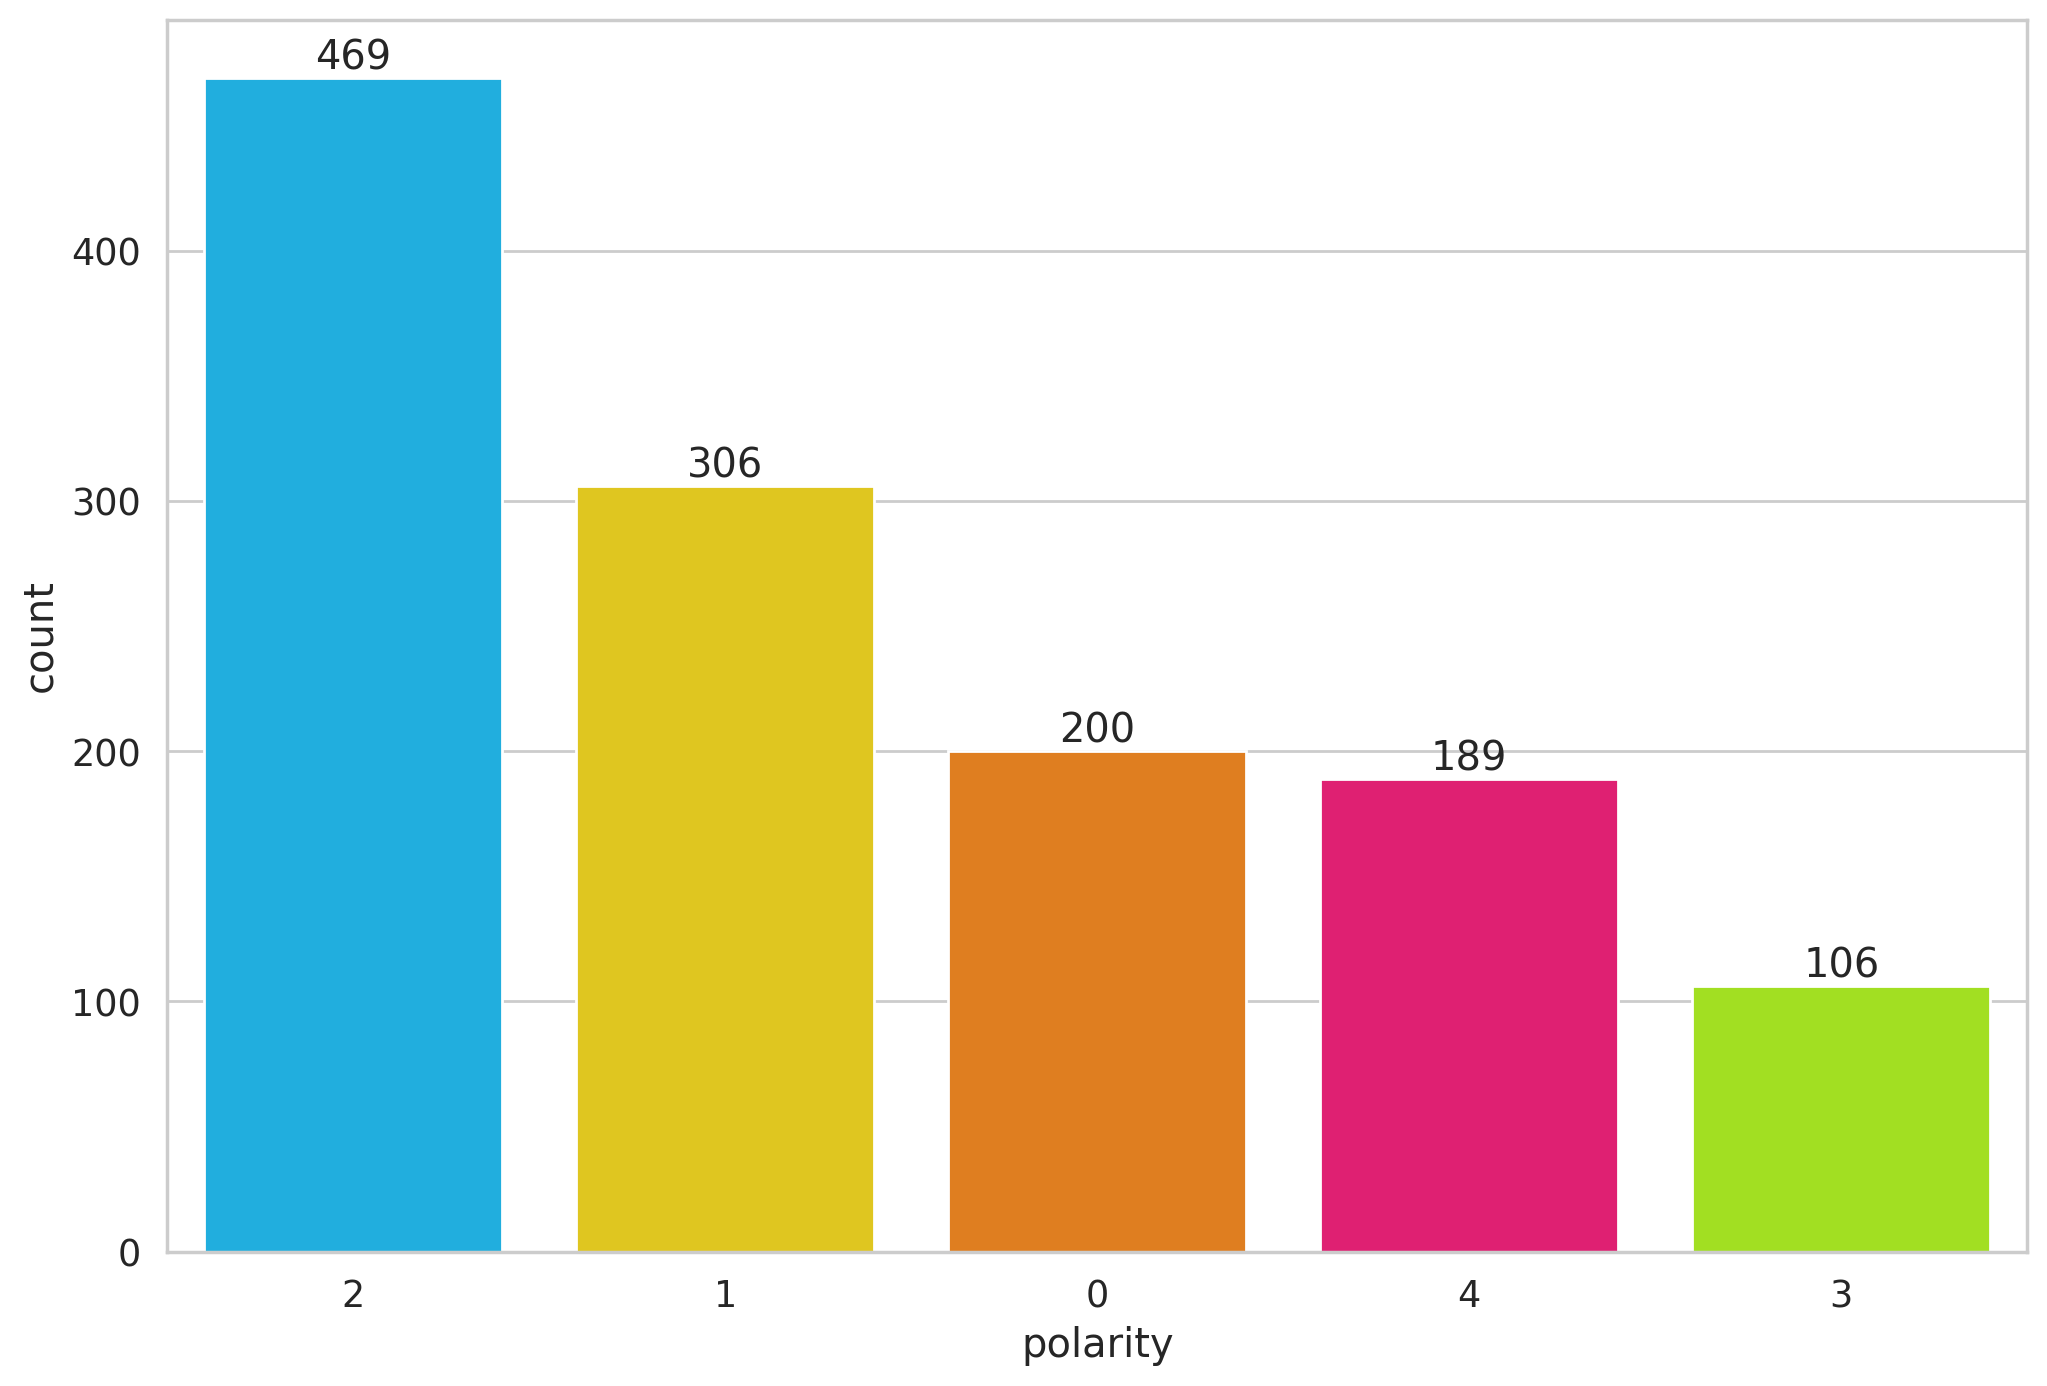

In [ ]:
ax = sns.countplot(x=df['polarity'], order=df['polarity'].value_counts(ascending=False).index);
abs_values = df['polarity'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

####**Labelling Rules (Data Training) :**

##### 0 = Negative,
##### 1 = Neutral,
##### 2 = Positive - (Product, BA and others)

In [ ]:
df_data = pd.read_csv('data_model.csv')
df_data = df_data.drop(columns=['date', 'is-retweet', 'username', 'name', 'profile_id', 'comments', 'retweets', 'quotes', 'likes', 'text_token'])

df_data_asli = pd.read_csv('data_model.csv')

df_data_asli.head(5)

,id_tweet,date,is-retweet,name,username,profile_id,comments,retweets,quotes,likes,text,text_stemming,text_token,polarity
0,0,"Oct 31, 2023 · 1:04 PM UTC",True,Make Your Move!,@ultramym,1197372091978276864,6,783,57,1809,"Btw, bakal ada premiere video #UltraMilkXStray...",btw bakal premiere video ultramilkxstraykids b...,"['btw', 'bakal', 'premiere', 'video', 'ultrami...",1
1,1,"Nov 2, 2023 · 11:45 PM UTC",False,Lau^^,@Seungminlock,1645021719734923264,0,0,0,1,"Naik krl di pagi hari yg cerah, sambil ngeliat...",naik krl pagi hari yg cerah ngeliatin barudak ...,"['naik', 'krl', 'pagi', 'hari', 'yg', 'cerah',...",3
2,2,"Nov 1, 2023 · 1:31 AM UTC",True,FELIX INDONESIA🇲🇨,@LeeFelixID,1641970160700657670,3,839,119,2288,[🐣] Wah pagi-pagi udah disambut @Stray_Kids d...,wah pagipagi udah sambut straykids sarinah ran...,"['wah', 'pagipagi', 'udah', 'sambut', 'strayki...",3
3,3,"Nov 2, 2023 · 10:20 AM UTC",True,Miho₋stay🐥🇯🇵🇮🇩,@Miho825_jkt,1665330990305406976,7,4,0,76,本日のウルトラミルクチャレンジは、 RASA KARAMEL=キャラメル味！ とっても甘く...,rasa karamel im japanese living in indonesia i...,"['rasa', 'karamel', 'im', 'japanese', 'living'...",2
4,4,"Nov 2, 2023 · 5:12 PM UTC",True,cilul 樂 ★,@youtiflul,1716136049519525888,0,2,0,4,oh that's why they're holding the mocha flavor...,thats why theyre holding the mocha flavored on...,"['thats', 'why', 'theyre', 'holding', 'the', '...",1


In [ ]:
df_data['labelled'] = 0
df_data_asli['labelled'] = 0
df_data.head(5)

,id_tweet,text,text_stemming,polarity,labelled
0,0,"Btw, bakal ada premiere video #UltraMilkXStray...",btw bakal premiere video ultramilkxstraykids b...,1,0
1,1,"Naik krl di pagi hari yg cerah, sambil ngeliat...",naik krl pagi hari yg cerah ngeliatin barudak ...,3,0
2,2,[🐣] Wah pagi-pagi udah disambut @Stray_Kids d...,wah pagipagi udah sambut straykids sarinah ran...,3,0
3,3,本日のウルトラミルクチャレンジは、 RASA KARAMEL=キャラメル味！ とっても甘く...,rasa karamel im japanese living in indonesia i...,2,0
4,4,oh that's why they're holding the mocha flavor...,thats why theyre holding the mocha flavored on...,1,0


In [ ]:
# Function to convert score to sentiment
def to_sentiment(rating):
    rating = int(rating)
    # Convert to class
    if rating == 0:
      return 0
    elif rating == 1:
      return 1
    elif rating == 2 or rating == 3:
      return 2

# Apply to the dataset
df_data['labelled'] = df_data.polarity.apply(to_sentiment)
df_data_asli['labelled'] = df_data_asli.polarity.apply(to_sentiment)

In [ ]:
df_data_asli.head(5)

,id_tweet,date,is-retweet,name,username,profile_id,comments,retweets,quotes,likes,text,text_stemming,text_token,polarity,labelled
0,0,"Oct 31, 2023 · 1:04 PM UTC",True,Make Your Move!,@ultramym,1197372091978276864,6,783,57,1809,"Btw, bakal ada premiere video #UltraMilkXStray...",btw bakal premiere video ultramilkxstraykids b...,"['btw', 'bakal', 'premiere', 'video', 'ultrami...",1,1.0
1,1,"Nov 2, 2023 · 11:45 PM UTC",False,Lau^^,@Seungminlock,1645021719734923264,0,0,0,1,"Naik krl di pagi hari yg cerah, sambil ngeliat...",naik krl pagi hari yg cerah ngeliatin barudak ...,"['naik', 'krl', 'pagi', 'hari', 'yg', 'cerah',...",3,2.0
2,2,"Nov 1, 2023 · 1:31 AM UTC",True,FELIX INDONESIA🇲🇨,@LeeFelixID,1641970160700657670,3,839,119,2288,[🐣] Wah pagi-pagi udah disambut @Stray_Kids d...,wah pagipagi udah sambut straykids sarinah ran...,"['wah', 'pagipagi', 'udah', 'sambut', 'strayki...",3,2.0
3,3,"Nov 2, 2023 · 10:20 AM UTC",True,Miho₋stay🐥🇯🇵🇮🇩,@Miho825_jkt,1665330990305406976,7,4,0,76,本日のウルトラミルクチャレンジは、 RASA KARAMEL=キャラメル味！ とっても甘く...,rasa karamel im japanese living in indonesia i...,"['rasa', 'karamel', 'im', 'japanese', 'living'...",2,2.0
4,4,"Nov 2, 2023 · 5:12 PM UTC",True,cilul 樂 ★,@youtiflul,1716136049519525888,0,2,0,4,oh that's why they're holding the mocha flavor...,thats why theyre holding the mocha flavored on...,"['thats', 'why', 'theyre', 'holding', 'the', '...",1,1.0


In [ ]:
# Delete Rows that has value 4 in Polarity
df_data = df_data[df.polarity != 4]
df_data.labelled

0       1.0
1       2.0
2       2.0
3       2.0
4       1.0
       ... 
1265    0.0
1266    0.0
1267    0.0
1268    0.0
1269    0.0
Name: labelled, Length: 1081, dtype: float64

In [ ]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, '575'), Text(0, 0, '306'), Text(0, 0, '200')]

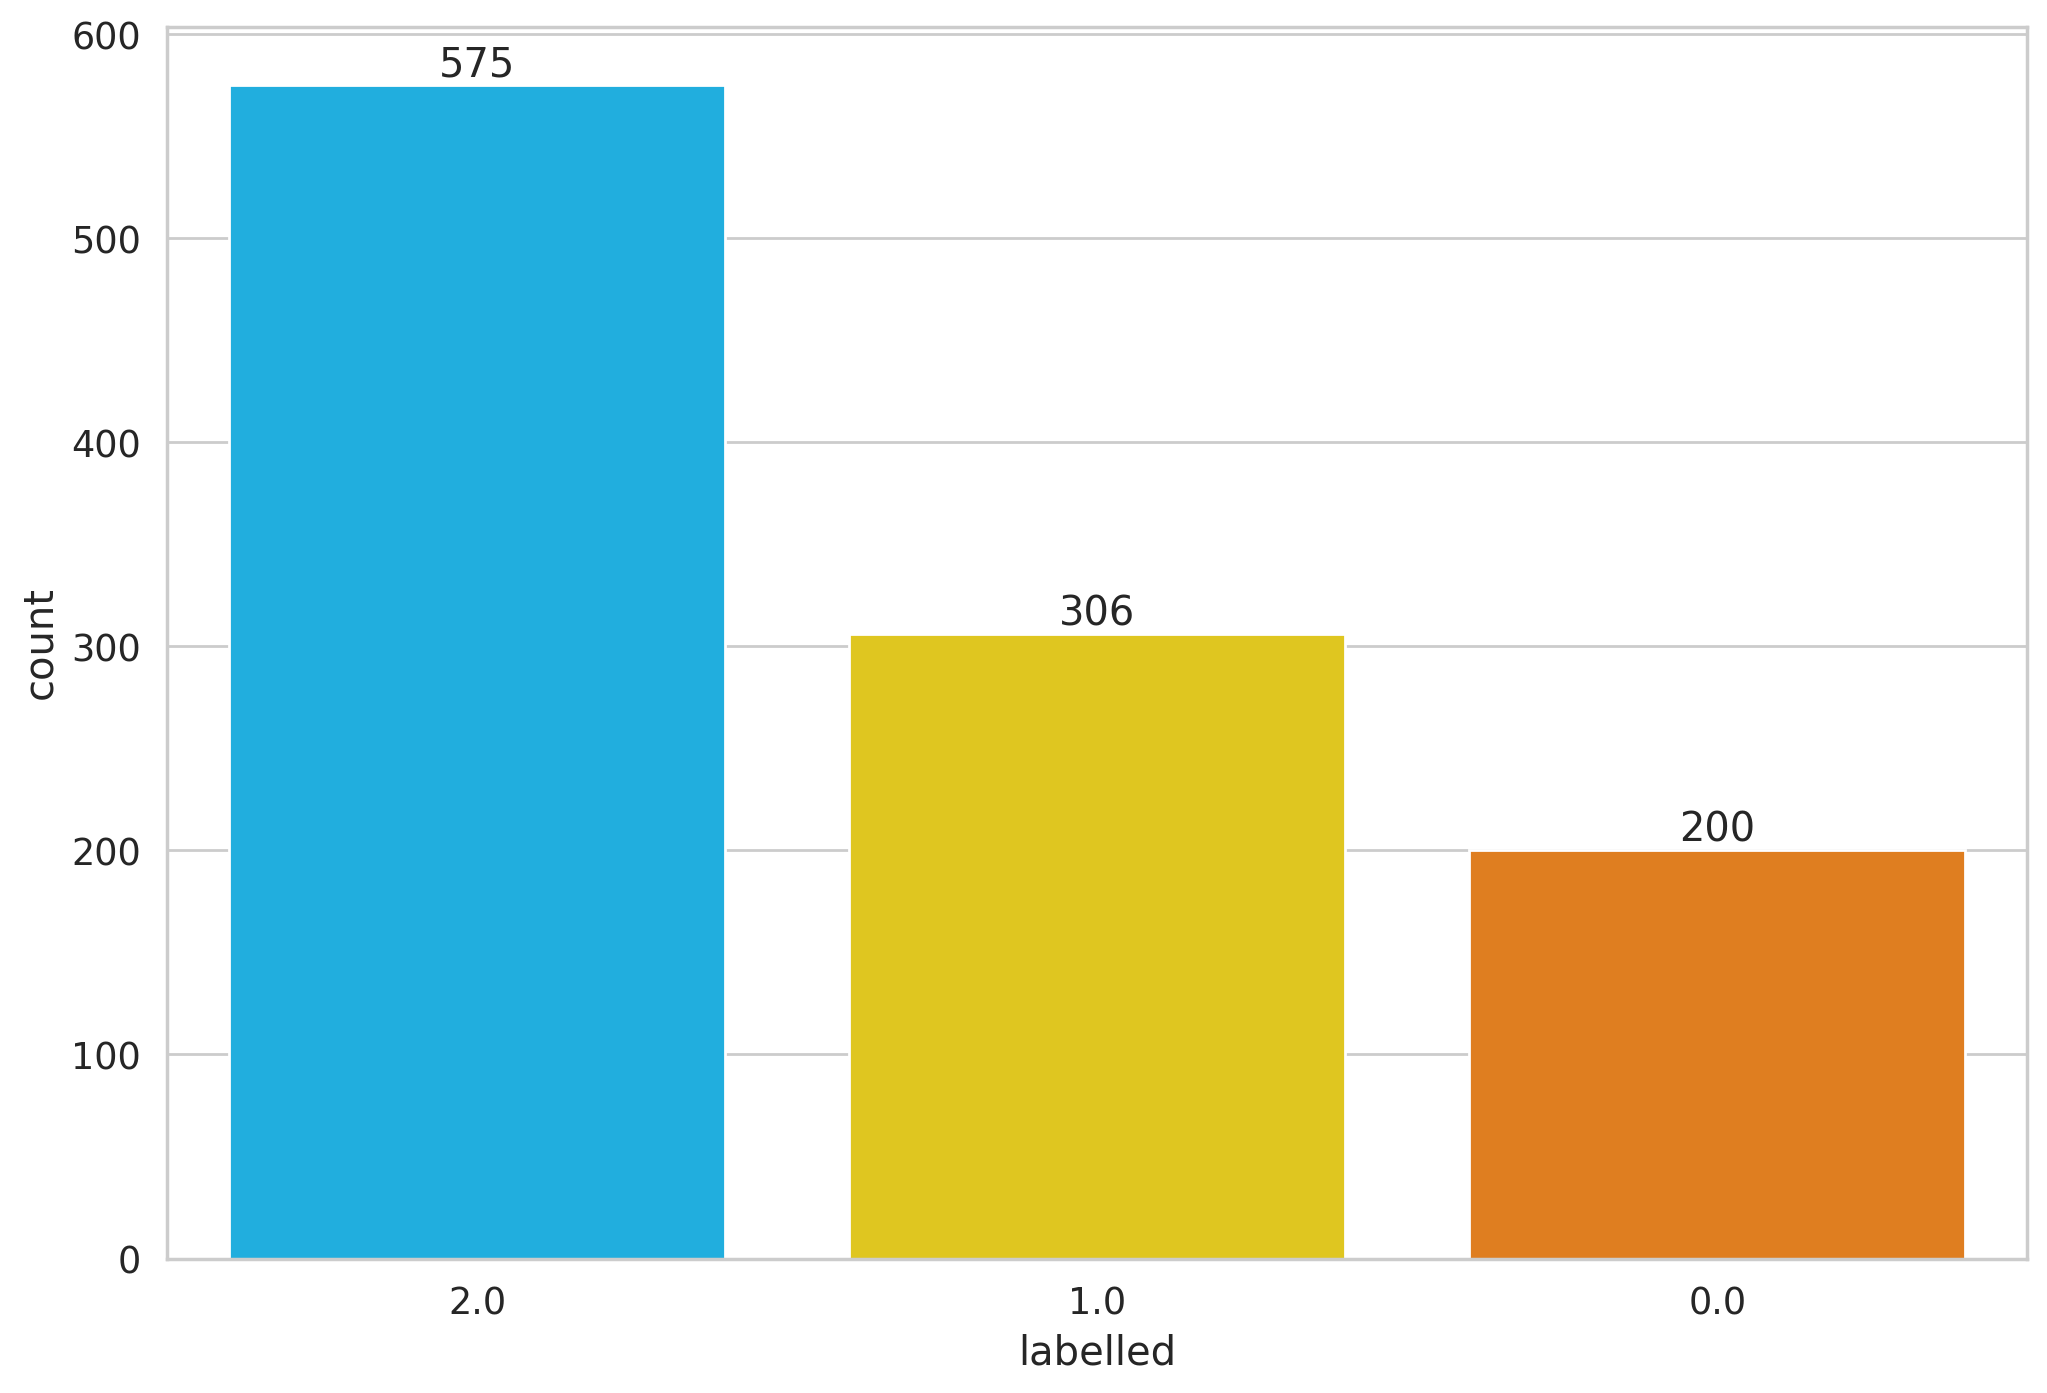

In [ ]:
ax = sns.countplot(x=df_data['labelled'], order=df_data['labelled'].value_counts(ascending=False).index);
abs_values = df_data['labelled'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

# **MODEL TRAINING**

In [ ]:
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = 'indolem/indobert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

(…)rt-base-uncased/resolve/main/config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

(…)bert-base-uncased/resolve/main/vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

(…)e-uncased/resolve/main/added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

(…)sed/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df_data.text_stemming:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<ipython-input-15-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


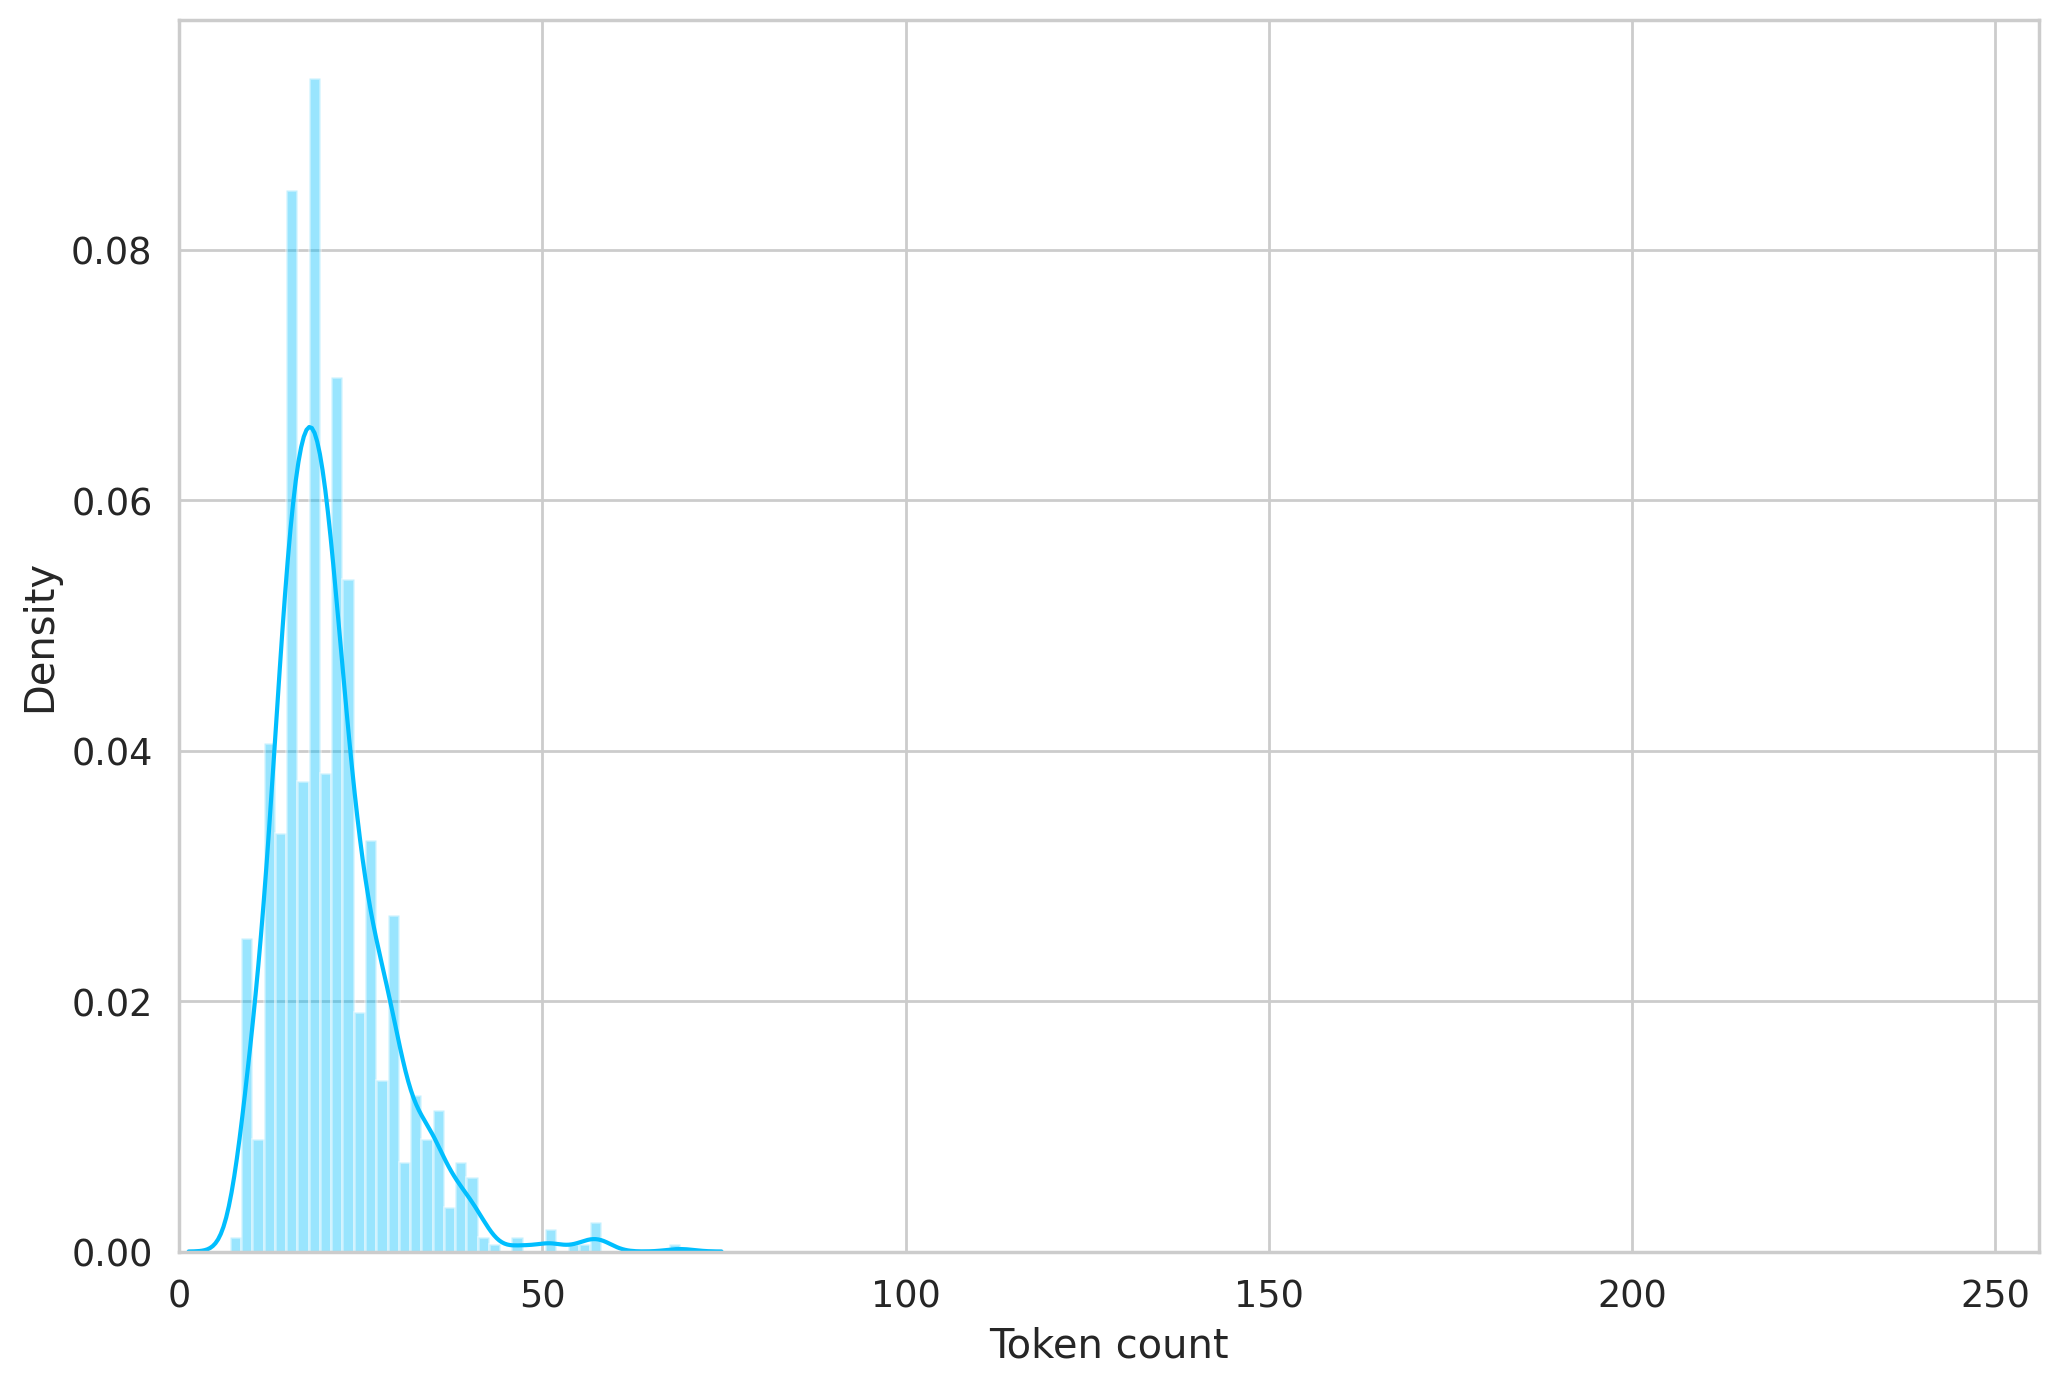

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 75

In [ ]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len, id_tweet):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.id_tweet = id_tweet

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        ##
        id_tweet = str(self.id_tweet[item])
        ##
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long),
            'id_tweet': id_tweet
        }

## **Dataset Splitting 80% Training, 10% Testing, 10% Validation**


In [ ]:
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(864, 5) (108, 5) (109, 5)


## **Data Loader**



In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text_stemming.to_numpy(),
        targets=df.labelled.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len,
        id_tweet=df.id_tweet.to_numpy()
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [ ]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
print(data['review_text'])
print(data['id_tweet'])

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets', 'id_tweet'])
torch.Size([16, 75])
torch.Size([16, 75])
torch.Size([16])
['mau hunting pc nya ahh ultramilkxstraykids', 'gokil parah bikin kece banget kolaborasi ultramilkxstraykids', 'kok stray kids kayak ultramilk ngebet banget cari perhati', 'yeyyy ayang collabs ma ultramilk otw nyetok nih ultramilkxstraykids', 'nang banget kerennyaaaaa ultramilkxstraykids gue ulang bosan', 'stray kids jadi brand ambassador ultramilk netral aja sih mungkin strategi marketing kita tau', 'kalo collab nya ultramilkxstraykids siapa yg bakal bosen gaadaa gak', 'jadi ba beneran nih keren banget ultramilkxstraykids', 'ultramilk kolaborasi sama stray kids hmm out of the box penasaran respon masyarakat', 'aaaa keren banget gokil parah mantap pokok nya ultramilkxstraykids', 'aaaa gemesss ga kuattt sambil bawa ultramilk ultramilkxstraykids', 'excited banget ga sih soal ultramilkxstraykids collab sama straykids', 'stray kids gak bisa bikin produ

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


##**Class Sentiment Classifier**

In [ ]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


##**Training Function**

In [ ]:
# Number of iterations
EPOCHS = 3

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

##**Training**

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc.detach().cpu().numpy())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.detach().cpu().numpy())
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state_e3_lr2e-5_bs16.bin')
        best_accuracy = val_acc

Epoch 1/3
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.6783052738066073 accuracy 0.6921296296296295
Val loss 0.6386136157172067 accuracy 0.8148148148148148

Epoch 2/3
----------
Train loss 0.2743423007842567 accuracy 0.9074074074074073
Val loss 0.659940330378179 accuracy 0.8518518518518519

Epoch 3/3
----------
Train loss 0.1878543034609821 accuracy 0.9537037037037036
Val loss 0.4996928730979562 accuracy 0.8703703703703703

CPU times: user 27 s, sys: 8.4 s, total: 35.4 s
Wall time: 49.3 s


##**Training History**


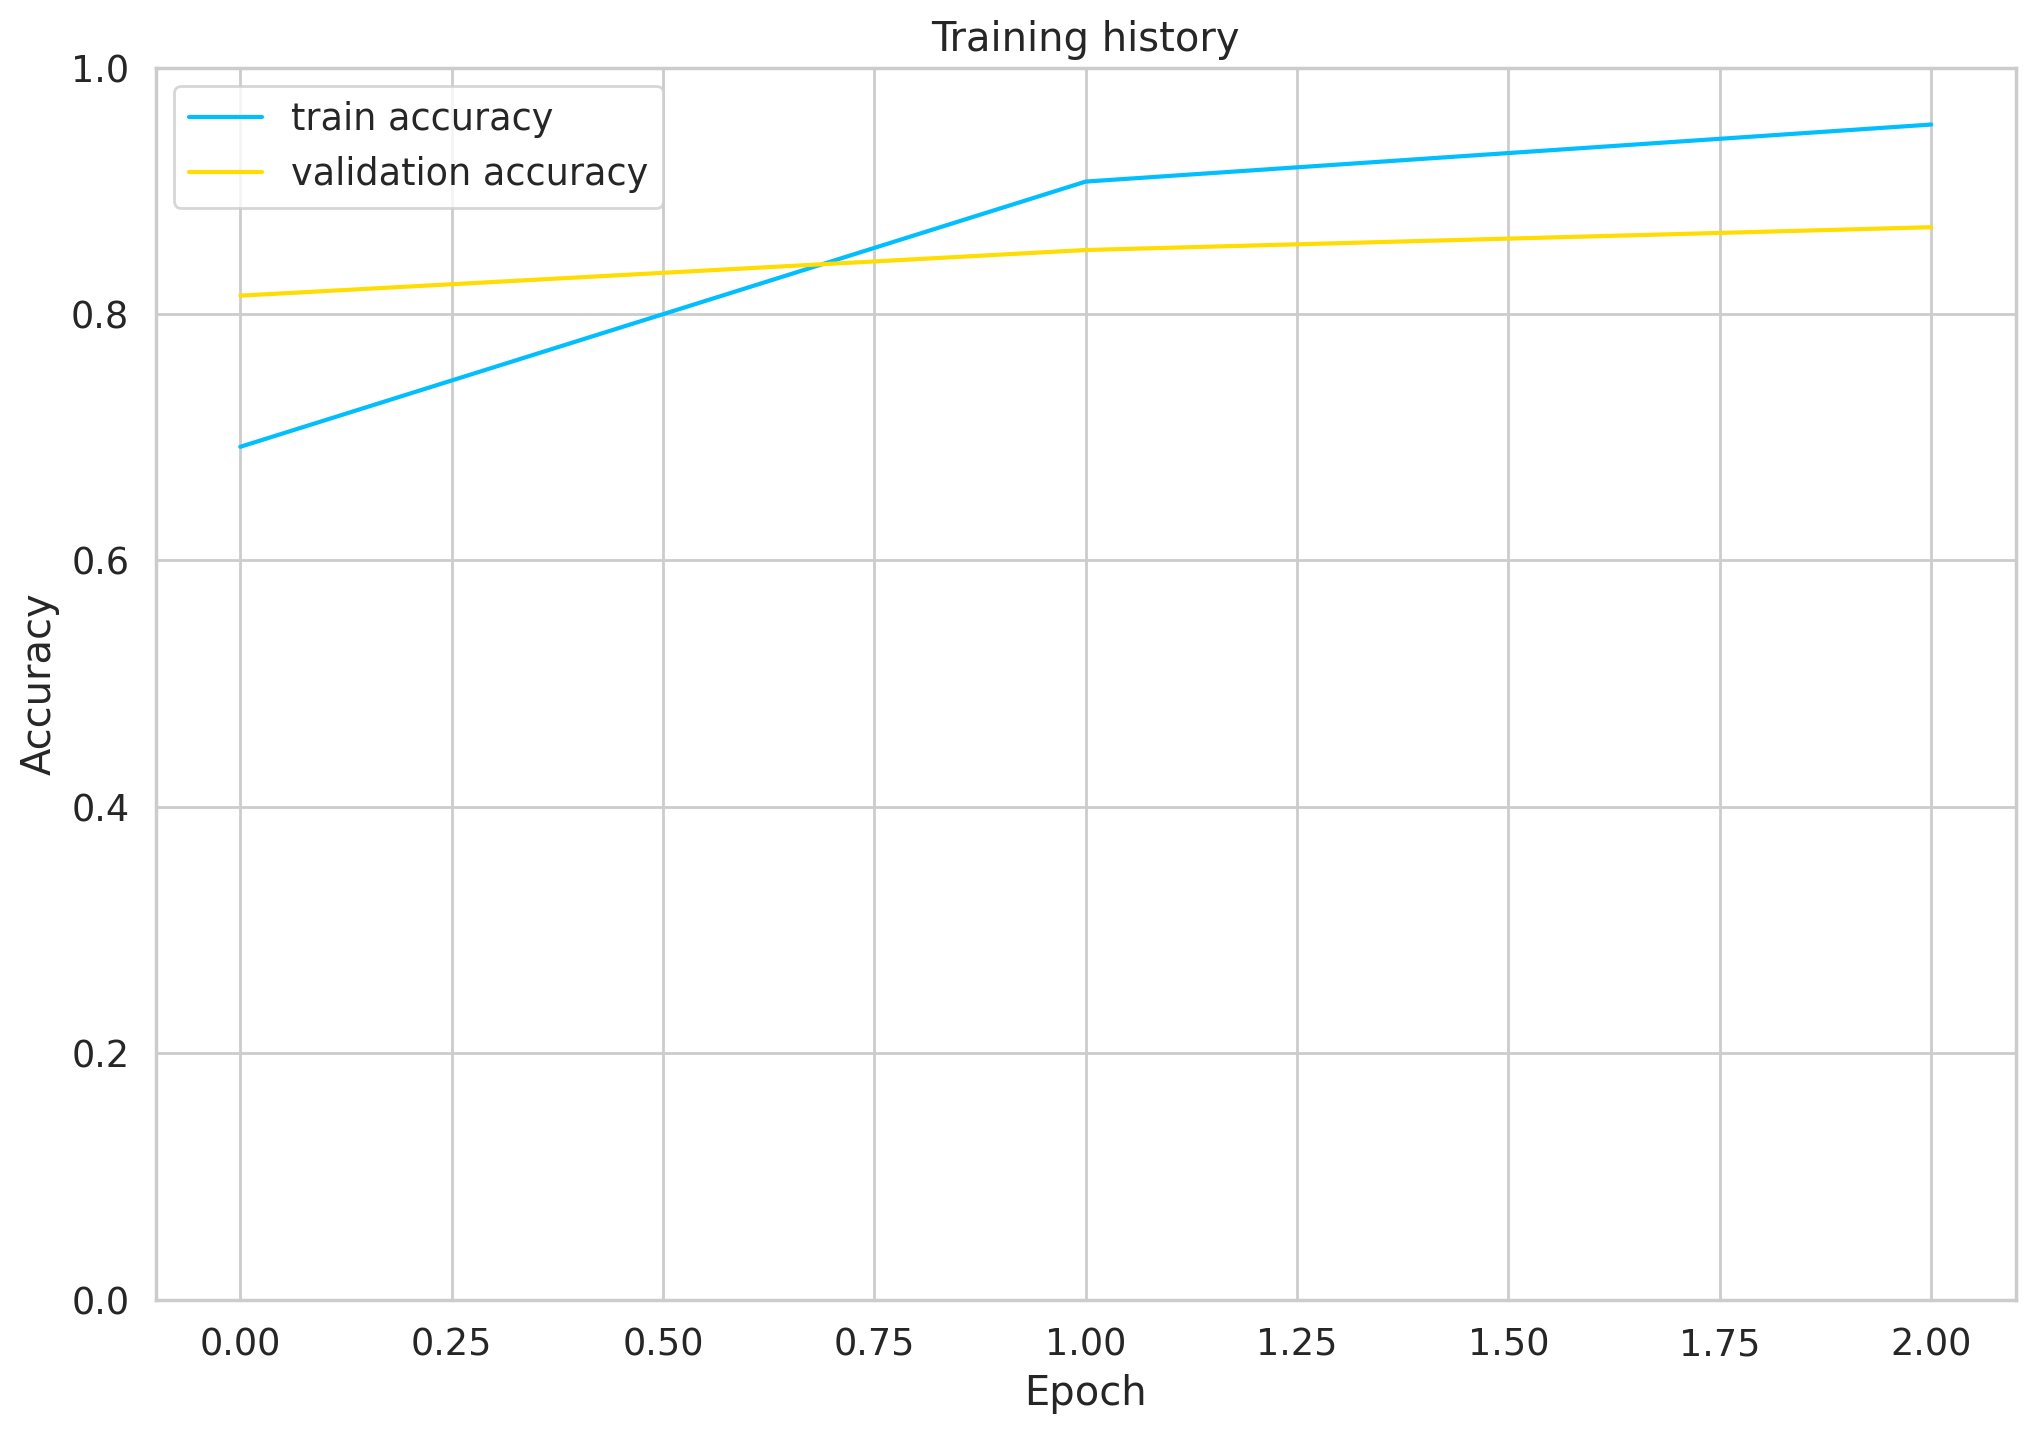

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

##**LOAD MODEL - Jika Diperlukan**


In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

##**Model Evaluation - Classification Report dan Confussion Matrixs**

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.963302752293578

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()

    ##
    id_text = []
    ##
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            ##
            id = d["id_tweet"]
            ##
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            ##
            id_text.extend(id)
            ##
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values, id_text

In [ ]:
## DATA UNTUK TRAINING RECAP
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_train_false = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_train_false.loc[len(df_train_false.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_testing']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_train_false['id_tweet']=df_train_false['id_tweet'].astype(int)

df_train_false

,id_tweet,predicted,status
0,921,Neutral,data_testing
1,596,Positive,data_testing
2,619,Positive,data_testing
3,607,Positive,data_testing
4,636,Positive,data_testing
...,...,...,...
104,460,Positive,data_testing
105,770,Positive,data_testing
106,1032,Neutral,data_testing
107,1244,Negative,data_testing


In [ ]:
## DATA UNTUK TRAINING RECAP
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    val_data_loader
)

def get_text(x):
  if x == 0:
    return "Negative"
  elif x == 1:
    return "Neutral"
  elif x == 2:
    return "Positive"

#id = id_texts.cpu().detach().numpy()
y_pred_numpy=y_pred.cpu().detach().numpy()
#print(y_pred_numpy)
y_test_numpy=y_test.cpu().detach().numpy()
#print(y_test_numpy)

df_validation = pd.DataFrame(columns=['id_tweet', 'predicted', 'status'])

for x in range(0,len(y_pred_numpy)) :
  #if y_pred_numpy[x] != y_test_numpy[x]:
  df_validation.loc[len(df_validation.index)] = [id_texts[x], get_text(y_pred_numpy[x]), 'data_validation']
  #print(y_review_texts[x] + ' | Labelled : '+get_text(y_test_numpy[x])+' | Predicted : ' +get_text(y_pred_numpy[x]))

#df_data.set_index('id_tweet').join(df_train_false.set_index('id_tweet'))
df_validation['id_tweet']=df_validation['id_tweet'].astype(int)

df_merge = pd.concat([df_train_false, df_validation], axis=0)
df_merge.reset_index(drop='true')
df_joined = df_data_asli.join(df_merge.set_index('id_tweet'), on='id_tweet')
df_joined.reset_index(drop="true")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


,id_tweet,date,is-retweet,name,username,profile_id,comments,retweets,quotes,likes,text,text_stemming,text_token,polarity,labelled,predicted,status
0,0,"Oct 31, 2023 · 1:04 PM UTC",True,Make Your Move!,@ultramym,1197372091978276864,6,783,57,1809,"Btw, bakal ada premiere video #UltraMilkXStray...",btw bakal premiere video ultramilkxstraykids b...,"['btw', 'bakal', 'premiere', 'video', 'ultrami...",1,1.0,NaN,NaN
1,1,"Nov 2, 2023 · 11:45 PM UTC",False,Lau^^,@Seungminlock,1645021719734923264,0,0,0,1,"Naik krl di pagi hari yg cerah, sambil ngeliat...",naik krl pagi hari yg cerah ngeliatin barudak ...,"['naik', 'krl', 'pagi', 'hari', 'yg', 'cerah',...",3,2.0,NaN,NaN
2,2,"Nov 1, 2023 · 1:31 AM UTC",True,FELIX INDONESIA🇲🇨,@LeeFelixID,1641970160700657670,3,839,119,2288,[🐣] Wah pagi-pagi udah disambut @Stray_Kids d...,wah pagipagi udah sambut straykids sarinah ran...,"['wah', 'pagipagi', 'udah', 'sambut', 'strayki...",3,2.0,Positive,data_validation
3,3,"Nov 2, 2023 · 10:20 AM UTC",True,Miho₋stay🐥🇯🇵🇮🇩,@Miho825_jkt,1665330990305406976,7,4,0,76,本日のウルトラミルクチャレンジは、 RASA KARAMEL=キャラメル味！ とっても甘く...,rasa karamel im japanese living in indonesia i...,"['rasa', 'karamel', 'im', 'japanese', 'living'...",2,2.0,Neutral,data_validation
4,4,"Nov 2, 2023 · 5:12 PM UTC",True,cilul 樂 ★,@youtiflul,1716136049519525888,0,2,0,4,oh that's why they're holding the mocha flavor...,thats why theyre holding the mocha flavored on...,"['thats', 'why', 'theyre', 'holding', 'the', '...",1,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,1265,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Kolaborasi ini terlalu mengejar tren, gak pun...",kolaborasi terlalu kejar tren gak punya karakt...,testing,0,0.0,NaN,NaN
1266,1266,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Stray Kids belum tentu bisa memberi kontribus...",stray kids tentu beri kontribusi positif buat ...,testing,0,0.0,Negative,data_validation
1267,1267,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Ini mah lebih kayak ngikutin tren, gak ada in...",ini mah lebih kayak ngikutin tren gak inovasi,testing,0,0.0,NaN,NaN
1268,1268,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Kolaborasi ini terlalu fokus sama citra, buka...",kolaborasi terlalu fokus sama citra bukan kual...,testing,0,0.0,NaN,NaN


In [ ]:
## Adding Data if polarity 4 and used for training
df_joined.loc[df_joined.polarity == 4, 'predicted'] = 'Not Predicted'
df_joined.loc[df_joined.polarity == 4, 'status'] = 'other'
df_joined.loc[df_joined.polarity == 4, 'labelled'] = 'Not Labelled'

df_joined.loc[df_joined.predicted.isnull() == True, 'predicted'] = 'Data Training'
df_joined.loc[df_joined.status.isnull() == True, 'status'] = 'data_training'
df_joined

,id_tweet,date,is-retweet,name,username,profile_id,comments,retweets,quotes,likes,text,text_stemming,text_token,polarity,labelled,predicted,status
0,0,"Oct 31, 2023 · 1:04 PM UTC",True,Make Your Move!,@ultramym,1197372091978276864,6,783,57,1809,"Btw, bakal ada premiere video #UltraMilkXStray...",btw bakal premiere video ultramilkxstraykids b...,"['btw', 'bakal', 'premiere', 'video', 'ultrami...",1,1.0,Data Training,data_training
1,1,"Nov 2, 2023 · 11:45 PM UTC",False,Lau^^,@Seungminlock,1645021719734923264,0,0,0,1,"Naik krl di pagi hari yg cerah, sambil ngeliat...",naik krl pagi hari yg cerah ngeliatin barudak ...,"['naik', 'krl', 'pagi', 'hari', 'yg', 'cerah',...",3,2.0,Data Training,data_training
2,2,"Nov 1, 2023 · 1:31 AM UTC",True,FELIX INDONESIA🇲🇨,@LeeFelixID,1641970160700657670,3,839,119,2288,[🐣] Wah pagi-pagi udah disambut @Stray_Kids d...,wah pagipagi udah sambut straykids sarinah ran...,"['wah', 'pagipagi', 'udah', 'sambut', 'strayki...",3,2.0,Positive,data_validation
3,3,"Nov 2, 2023 · 10:20 AM UTC",True,Miho₋stay🐥🇯🇵🇮🇩,@Miho825_jkt,1665330990305406976,7,4,0,76,本日のウルトラミルクチャレンジは、 RASA KARAMEL=キャラメル味！ とっても甘く...,rasa karamel im japanese living in indonesia i...,"['rasa', 'karamel', 'im', 'japanese', 'living'...",2,2.0,Neutral,data_validation
4,4,"Nov 2, 2023 · 5:12 PM UTC",True,cilul 樂 ★,@youtiflul,1716136049519525888,0,2,0,4,oh that's why they're holding the mocha flavor...,thats why theyre holding the mocha flavored on...,"['thats', 'why', 'theyre', 'holding', 'the', '...",1,1.0,Data Training,data_training
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,1265,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Kolaborasi ini terlalu mengejar tren, gak pun...",kolaborasi terlalu kejar tren gak punya karakt...,testing,0,0.0,Data Training,data_training
1266,1266,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Stray Kids belum tentu bisa memberi kontribus...",stray kids tentu beri kontribusi positif buat ...,testing,0,0.0,Negative,data_validation
1267,1267,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Ini mah lebih kayak ngikutin tren, gak ada in...",ini mah lebih kayak ngikutin tren gak inovasi,testing,0,0.0,Data Training,data_training
1268,1268,"Nov 14, 2023",False,Dummy-Data,@dummy_data,12345,111,222,333,444,"""Kolaborasi ini terlalu fokus sama citra, buka...",kolaborasi terlalu fokus sama citra bukan kual...,testing,0,0.0,Data Training,data_training


In [ ]:
df_joined.to_excel("data_report_training.xlsx")

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test, id_texts = get_predictions(
    model,
    test_data_loader
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        24
     neutral       0.97      0.91      0.94        33
    positive       0.94      0.98      0.96        52

    accuracy                           0.96       109
   macro avg       0.97      0.96      0.97       109
weighted avg       0.96      0.96      0.96       109



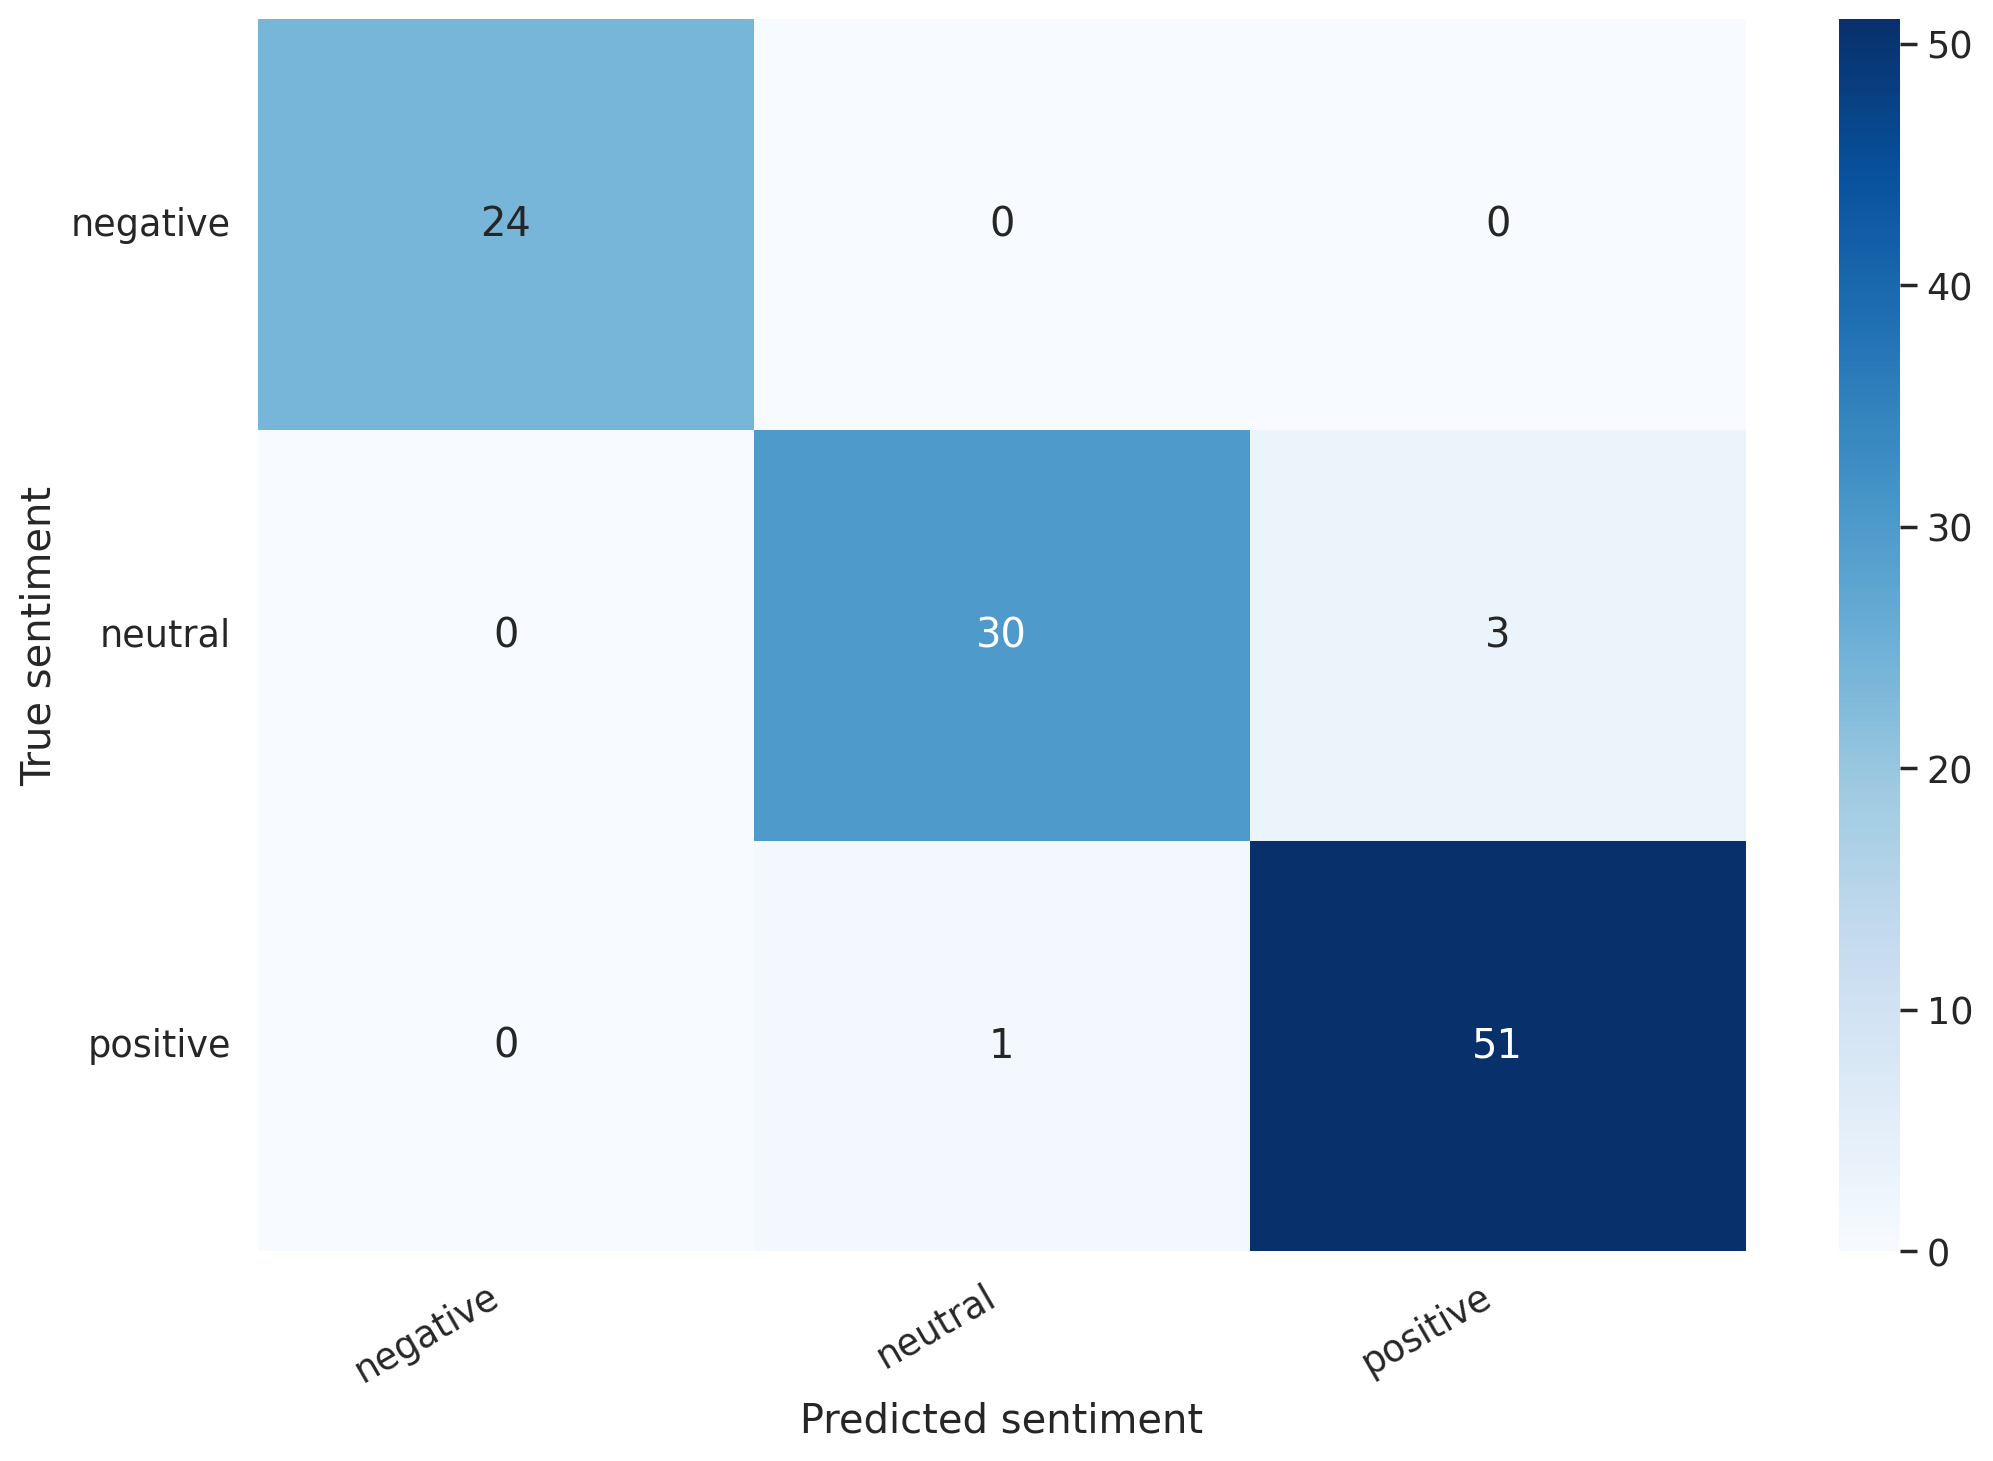

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
df_cm

,negative,neutral,positive
negative,24,0,0
neutral,0,30,3
positive,0,1,51


##**Test Predict**

In [ ]:
!pip install Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Indonesian Stopword by Sastrawi
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.1 MB/s eta 0:00:00


In [ ]:
def clean_text_predict(text) :
    # REMOVE PUNCTUATION
    ## Remove hashtag dan @
    ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    ## Remove punctiation
    text  = "".join([char for char in text if char not in string.punctuation])
    ## Remove angka
    text = re.sub('[0-9]+', '', text)
    ## Remove website link
    text = re.sub(r'http\S+', '', text)

    # REMOVE STOPWORD
    text = stopword.remove(text)

    # TEXT STEMMING
    text = stemmer.stem(text)

    return text

In [ ]:
review_text = "Wah sangat disayangkan kenapa ba nya stray kids kyk ga ada artist indonesia lainnya."
txt_clean = clean_text_predict(review_text)

encoded_review = tokenizer.encode_plus(
    txt_clean,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text\t: {review_text}')
print(f'Clean text\t: {txt_clean}')
print(f'Sentiment\t: {class_names[prediction]}')

Review text	: Wah sangat disayangkan kenapa ba nya stray kids kyk ga ada artist indonesia lainnya.
Clean text	: wah sangat sayang ba nya stray kids kyk ga artist indonesia lain
Sentiment	: negative


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def predict_sentiment(text) :
  # Preprocess Data Text
  txt_clean = clean_text_predict(text)

  # Set Parameter Input
  encoded_review = tokenizer.encode_plus(
      txt_clean,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
  )

  # Transform Data to Tensors
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  # Predict
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  # Return Data
  return class_names[prediction]

In [ ]:
df_test.reset_index(drop='true')

,id_tweet,text,text_stemming,polarity,labelled
0,921,"""Ultramilk kolaborasi sama Stray Kids, keputus...",ultramilk kolaborasi sama stray kids putus cuk...,1,1.0
1,596,akhirnya yang ditunggu setelah hanya rumor sem...,akhir tunggu hanya rumor semata rilis official...,2,2.0
2,619,luucuuuwww banet dehh keren polll #UltraMilkXS...,luucuuuwww banet dehh keren polll ultramilkxst...,2,2.0
3,607,ikut kaget juga aku aja baru tau ultramilk ada...,ikut kaget aku aja baru tau ultramilk collab s...,1,1.0
4,636,anjayy duo fav malah collab😭😍 #UltraMilkXStray...,anjayy duo fav malah collab ultramilkxstraykids,2,2.0
...,...,...,...,...,...
104,460,"Woy demi apa, collabs ultramilk produk kesuka...",woy apa collabs ultramilk produk suka gue buru...,2,2.0
105,770,Wah udah official ya #UltraMilkXStrayKids baka...,wah udah official ultramilkxstraykids bakal bo...,2,2.0
106,1032,"""Stray Kids di iklan susu lokal, lumayan kejut...",stray kids iklan susu lokal lumayan kejut netr...,1,1.0
107,1244,"""Stray Kids belum tentu bisa bikin produk ini ...",stray kids tentu bikin produk jadi laris pasar,0,0.0


In [ ]:
#df_test['prediction'] = df_test['text_stemming'].apply(lambda x: predict_sentiment(x))
#df_test

In [ ]:
#def check_predict(sentiment, prediction):
#  if sentiment == 0 and prediction == 'negative' :
#    return 'benar'
#  elif sentiment == 1 and prediction == 'neutral' :
#    return 'benar'
#  elif sentiment == 2 and prediction == 'positive' :
#    return 'benar'
#  else :
#    return 'salah'

In [ ]:
#df_test['hasil'] = df_test.apply(lambda x: check_predict(x['sentiment'], x['prediction']), axis=1)
#df_test

In [ ]:
#df_test.to_excel("data_test_training.xlsx")